# Project: Plant Seedlings Classification.

### Data Description:

- You are provided with a training set and a test set of images of plant seedlings at various stages of grown. 
- Each image has a filename that is its unique id. 
- The dataset comprises 12 plant species.
- The goal of the competition is to create a classifier capable of determining a plant's species from a photo.

### Dataset:
- The project is from a dataset from Kaggle.
- Link to the Kaggle project site:https://www.kaggle.com/c/plant-seedlings-classification/data
- The dataset has to be downloaded from the above Kagglewebsite.

### Context:

- Can you differentiate a weed from a crop seedling?
- The ability to do so effectively can mean better crop yields and better stewardship of the environment.
- The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages.

### Objective:
- To implement the techniques learnt as a part of the course.

### Learning Outcomes:
- Pre-processing of image data.
- Visualization of images.
- Building CNN.
- Evaluate the Model.

# Import necessary libraries

In [1]:
# Import necessary libraries.
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Set the path to the dataset folder. (The dataset contains image folder: "train")
train_path = "/content/drive/My Drive/Colab Notebooks/data/plant seedlings/train.zip"

In [4]:
# Make different folders for train and test data in the current directory of Google Colab notebook. (using mkdir)
!mkdir temp_train

# Unziping train file:

In [5]:
# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall('./temp_train')

In [6]:
path = "./temp_train/*/*.png"                              # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = np.array(trainLabel)  # Train labels set

# Shape of the train set and labels set

In [7]:
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750,)


In [8]:
trainLabel

array(['Small-flowered Cranesbill', 'Small-flowered Cranesbill',
       'Small-flowered Cranesbill', ..., 'Maize', 'Maize', 'Maize'],
      dtype='<U25')

# Visualize the image

Label 
 Name: Small-flowered Cranesbill 


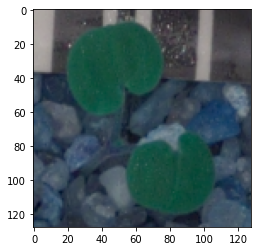

In [9]:
i = 0
image = trainImg[i]
label = trainLabel[i]
print(f'Label \n Name: {label} ')
plt.imshow(image);

- As we can see the x-axis and y-axis of image, it shows that there are 128 pixels on each directions.
- The image quality is good.
- Also the image is a color image and not grey scale.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


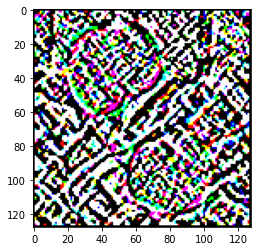

In [10]:
sobel = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

- From the image we are not able to visualize the edges clearly because of the background.
- Suppose, if we remove the backgroud in the image, we can visualize the edges clearly and helps model predict easily.

# Number of images in each class

In [11]:
  
for label in set(trainLabel):
    print("Number of {} images is  -> {}".format(label,len(trainImg[trainLabel == label])))

Number of Charlock images is  -> 390
Number of Shepherds Purse images is  -> 231
Number of Cleavers images is  -> 287
Number of Scentless Mayweed images is  -> 516
Number of Black-grass images is  -> 263
Number of Small-flowered Cranesbill images is  -> 496
Number of Common wheat images is  -> 221
Number of Fat Hen images is  -> 475
Number of Common Chickweed images is  -> 611
Number of Sugar beet images is  -> 385
Number of Loose Silky-bent images is  -> 654
Number of Maize images is  -> 221



# Plot the distrbution of number of images

Text(0.5, 0.98, 'Categorical Plotting')

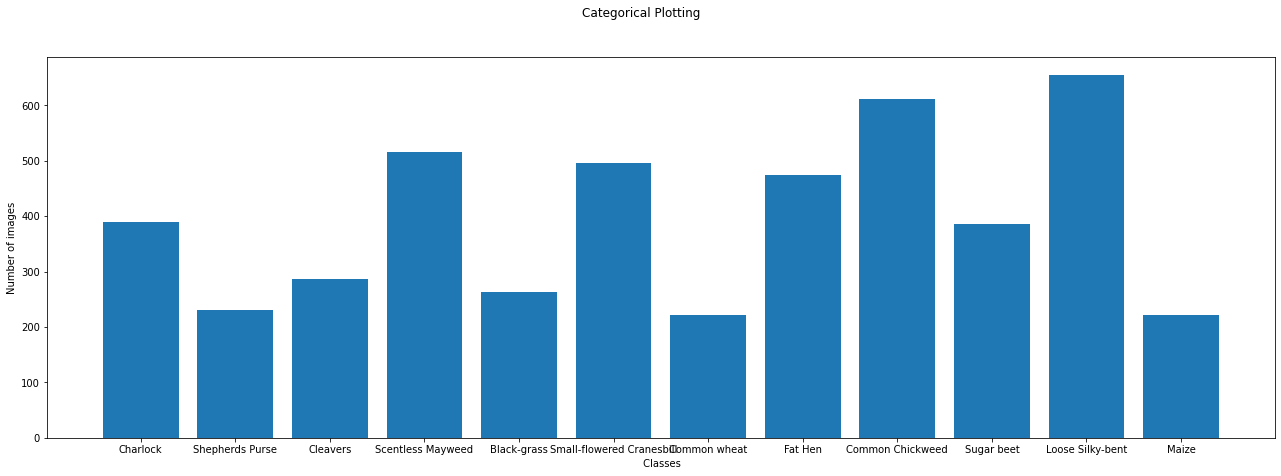

In [12]:
values =[]
labels=[]
for label in set(trainLabel):
  values.append(len(trainImg[trainLabel == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" Classes")
ax.set_ylabel("Number of images")
fig.suptitle('Categorical Plotting')

- We can see from the above plot that the data is unevenly distributed among all the classes (from 0, 1, 2, ..., 10, 11). So, the dataset is not perfectly balanced.
- Maize and common wheat have same number of records.

# Data Preprocessing


- Gaussian blurring
- Convert RGB to HSV

### Masking

Since all the plants are in green, we can use the masking process to remove the background. Masking will leave some range of green color in the image and remove all other parts of the image.

- Create mask
- Create boolean mask
- Apply boolean mask and getting image without background


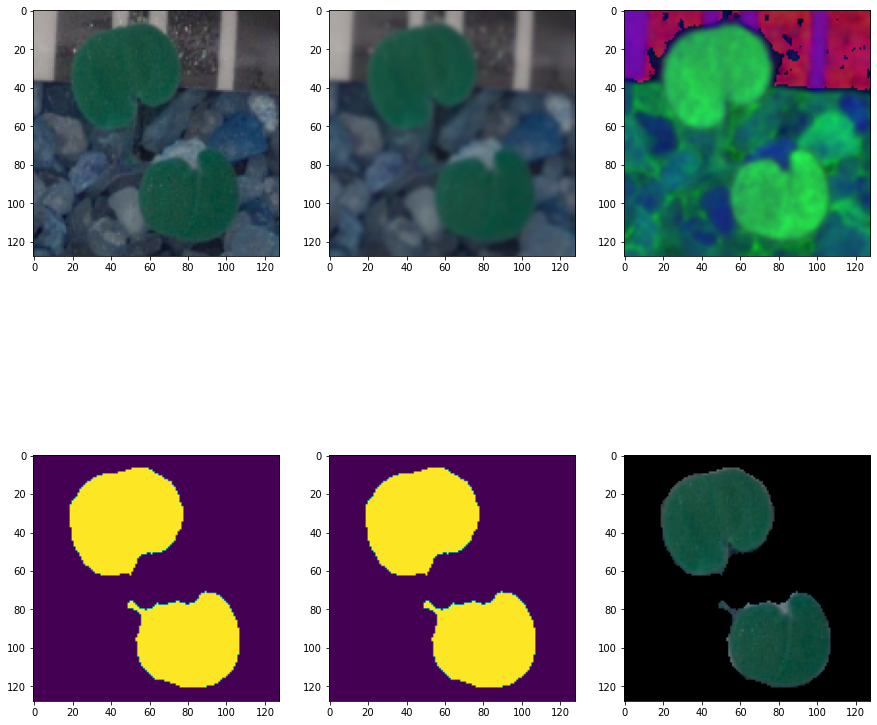

In [13]:
clearTrainImg = []
examples = []; getEx = True
plt.figure(figsize=(15,15))
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

- In Masking, first covert RGB to HSV since HSV is easier to represent color range. second, blur the image to remove noise. after that based on the range of green color create a mask and convert into boolean mask and apply it to the origin image.
- We can see from the last plot, the image contains a plant without background.
- Also, we can visualize the edges clearly.


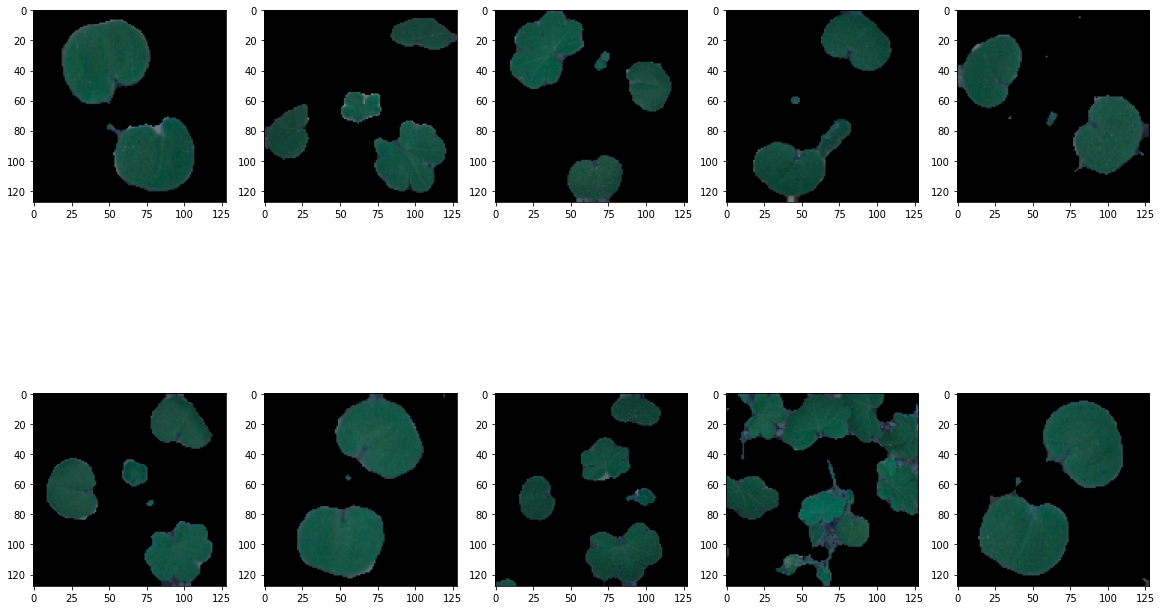

In [14]:
# Sample Result of some other images
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(3, 5, i+1)
    plt.imshow(clearTrainImg[i])

- From the above plot we can see most of the background is removed from the image leaving only green part which is the plant.

# Normalisation

In [15]:
#normalize 
clearTrainImg = clearTrainImg.astype('float32')

clearTrainImg /= 255   # make 0,1 as input to the model


In [16]:
clearTrainImg.shape

(4750, 128, 128, 3)

# Reshape train and test sets into compatible shapes

In [17]:
clearTrainImg = clearTrainImg.reshape(clearTrainImg.shape[0], 128, 128, 3)

# Train, Test and Validation split

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


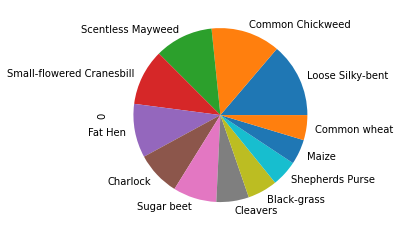

In [18]:
# Convert labels to one hot vectors.
trainLabel = pd.DataFrame(trainLabel)

from keras.utils import np_utils
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_classes = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_classes))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='pie')


In [19]:
clearTrainLabel[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [20]:
# test and train split

from sklearn.model_selection import train_test_split

X_train, x_test, Y_train, y_test = train_test_split(clearTrainImg, clearTrainLabel, test_size=0.3, random_state=42,stratify = clearTrainLabel)

In [21]:
print("X train shape:" ,X_train.shape)
print("Y_train shape:",Y_train.shape)

X train shape: (3325, 128, 128, 3)
Y_train shape: (3325, 12)


## Print the label for Y_train[0]

In [22]:
#print the label for Y_train[0]
print(Y_train[0])
label = np.argmax(Y_train[0])
print("\n Label : {}".format(le.classes_[label]))

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

 Label : Loose Silky-bent


# Validation split

In [23]:
X_test, X_val, Y_test, Y_val = train_test_split(x_test,y_test, test_size = 0.5, random_state=2)  # test is 50% and validation set is 50%


In [24]:
print("X test shape:" ,X_test.shape)
print("Y test shape:",Y_test.shape)
print("X val shape:" ,X_val.shape)
print("Y val shape:",Y_val.shape)

X test shape: (712, 128, 128, 3)
Y test shape: (712, 12)
X val shape: (713, 128, 128, 3)
Y val shape: (713, 12)


# Image Data Generator to avoid model overfitting


In [25]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X_train)

# Build the model

- I created model with six convolutional layers and three fully-connected layers. 

- First two convolutional layers have 64 filters, next with 128 filters and the last two layers have 256 filters. After each pair of convolution layers, I add max pooling layer. 

- Also, to reduce overfitting after each pair of convolution layers I used dropout layer (10% between convolutional layers and 50% between fully connect layers) and between each layer we use batch normalization layer.

- In the end I used three fully-connected layers for classifying where last layer is for distribution of probability for each of 12 classes using softmax.

In [26]:
from keras.layers.convolutional import MaxPooling2D
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(128, 128, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       2

In [27]:
#opt ='adam' #When I used adam optimizer I didn't get the best results so I used RMSprop.
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       2

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.000001)

# checkpoints
model_checkpoint =  ModelCheckpoint('plant_checkpoint_{epoch:02d}_accuracy{val_accuracy:.4f}.h5',
                                                           monitor='val_accuracy',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='max')

#Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

#all callbacks
callbacks_list = [learning_rate_reduction, model_checkpoint, early_stopping]



# Model fit with training and validation set

In [30]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=75), 
                            epochs=100, validation_data=(X_val,Y_val),
                            callbacks=callbacks_list)

Epoch 1/100
45/45 [==============================] - 60s 463ms/step - loss: 2.9678 - accuracy: 0.2187 - val_loss: 23.4495 - val_accuracy: 0.0617

Epoch 00001: val_accuracy improved from -inf to 0.06171, saving model to plant_checkpoint_01_accuracy0.0617.h5
Epoch 2/100
45/45 [==============================] - 16s 350ms/step - loss: 2.0225 - accuracy: 0.3722 - val_loss: 54.4911 - val_accuracy: 0.0757

Epoch 00002: val_accuracy improved from 0.06171 to 0.07574, saving model to plant_checkpoint_02_accuracy0.0757.h5
Epoch 3/100
45/45 [==============================] - 16s 353ms/step - loss: 1.7067 - accuracy: 0.4531 - val_loss: 92.6974 - val_accuracy: 0.0687

Epoch 00003: val_accuracy did not improve from 0.07574
Epoch 4/100
45/45 [==============================] - 16s 351ms/step - loss: 1.4474 - accuracy: 0.5348 - val_loss: 66.4990 - val_accuracy: 0.0856

Epoch 00004: val_accuracy improved from 0.07574 to 0.08555, saving model to plant_checkpoint_04_accuracy0.0856.h5
Epoch 5/100
45/45 [===

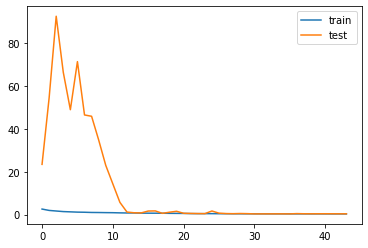

In [31]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- From the above plot we can see at first the loss was more and the model gradually improves.
- The Final Train accuracy I achieved is 0.90 (90%) and validation accuracy of 0.8976 (89%)

# Test Accuracy

In [32]:
# Score trained model.
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 1s 57ms/step - loss: 0.2821 - accuracy: 0.8876
Test loss: 0.2821074426174164
Test accuracy: 0.8876404762268066


- Test accuracy : 0.8876 (88%)

# Confusion Matrix

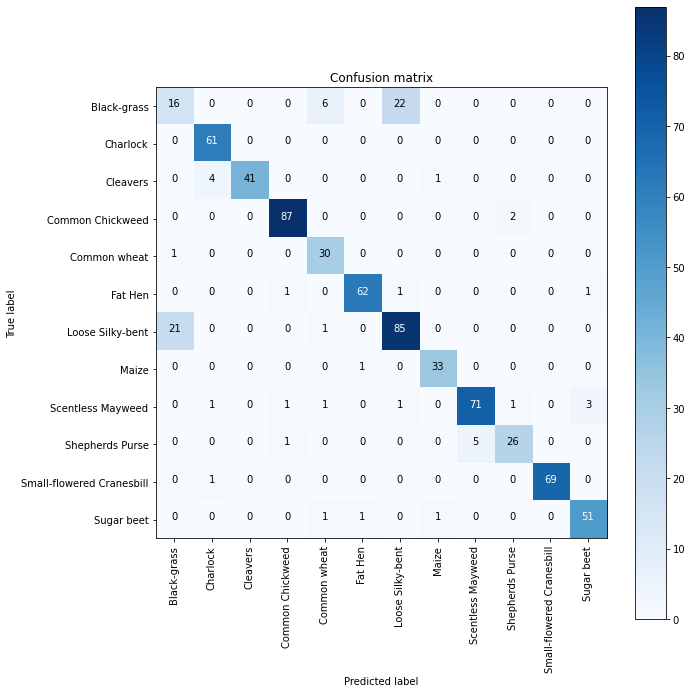

In [33]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
Y_pred = model.predict(X_test)
Y_predClasses = np.argmax(Y_pred, axis = 1) 
Y_true = np.argmax(Y_test, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(Y_true, Y_predClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

- From the confusion matrix we can see some good predictions. Only Black grass and loose silky bent are little poorly predicted.

# Prediction for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

Predicted class: Small-flowered Cranesbill

 Actual class: Small-flowered Cranesbill

 Predicted label: 10

 Softmax Outputs: [[4.6252003e-06 2.3297705e-04 8.2959846e-04 9.6341988e-05 4.6648474e-06
  4.8126527e-05 8.5487836e-06 4.1462936e-05 9.1430102e-06 1.4143082e-04
  9.9852955e-01 5.3492306e-05]]

 Sum of softmax outputs: 0.99999994


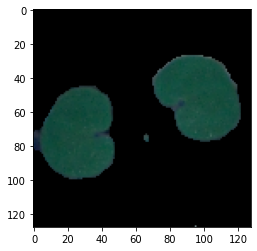

In [34]:
plt.imshow(X_test[2])
pred = model.predict(X_test[2].reshape(1, 128, 128, 3))
act = np.argmax(Y_test[2])
print("Predicted class: {}".format(le.classes_[pred.argmax()]))
print("\n Actual class: {}".format(le.classes_[act]))
print("\n Predicted label:", pred.argmax())
print("\n Softmax Outputs:", pred)
print("\n Sum of softmax outputs:",pred.sum())



The model correctly predicted small-flowered cranesbill.

Predicted class: Scentless Mayweed

 Actual class: Scentless Mayweed

 Predicted label: 8

 Softmax Outputs: [[0.01147294 0.00829858 0.00364463 0.01106784 0.15263514 0.01367036
  0.01945928 0.04396353 0.4347638  0.00692234 0.00077754 0.293324  ]]

 Sum of softmax outputs: 1.0


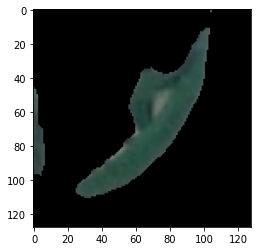

In [35]:
plt.imshow(X_test[3])
pred = model.predict(X_test[3].reshape(1, 128, 128, 3))
act = np.argmax(Y_test[3])
print("Predicted class: {}".format(le.classes_[pred.argmax()]))
print("\n Actual class: {}".format(le.classes_[act]))
print("\n Predicted label:", pred.argmax())
print("\n Softmax Outputs:", pred)
print("\n Sum of softmax outputs:",pred.sum())



The model correctly predicted Scentless Mayweed.

Predicted class: Black-grass

 Actual class: Loose Silky-bent

 Predicted label: 0

 Softmax Outputs: [[6.21073604e-01 1.07220485e-05 1.17219330e-04 2.45404626e-05
  4.67663296e-02 2.48390803e-04 3.31339240e-01 1.74925182e-04
  8.33269150e-05 8.58687872e-06 1.27351217e-04 2.57567190e-05]]

 Sum of softmax outputs: 1.0


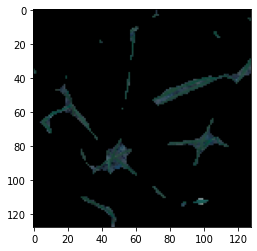

In [36]:
plt.imshow(X_test[33])
pred = model.predict(X_test[33].reshape(1, 128, 128, 3))
act = np.argmax(Y_test[33])
print("Predicted class: {}".format(le.classes_[pred.argmax()]))
print("\n Actual class: {}".format(le.classes_[act]))
print("\n Predicted label:", pred.argmax())
print("\n Softmax Outputs:", pred)
print("\n Sum of softmax outputs:",pred.sum())



The model incorrectly predicted Loose Silky-bent as Black-grass

Predicted class: Loose Silky-bent

 Actual class: Loose Silky-bent

 Predicted label: 6

 Softmax Outputs: [[4.6010950e-01 2.1325479e-05 2.3705125e-04 1.7465401e-04 5.4367371e-03
  5.7264087e-03 5.2518827e-01 4.8391926e-04 6.4567655e-05 4.6633180e-05
  4.5953874e-04 2.0514831e-03]]

 Sum of softmax outputs: 1.0000001


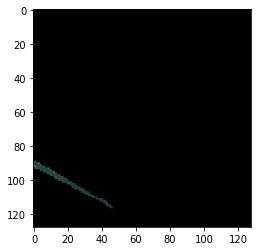

In [37]:
plt.imshow(X_test[36])
pred = model.predict(X_test[36].reshape(1, 128, 128, 3))
act = np.argmax(Y_test[36])
print("Predicted class: {}".format(le.classes_[pred.argmax()]))
print("\n Actual class: {}".format(le.classes_[act]))
print("\n Predicted label:", pred.argmax())
print("\n Softmax Outputs:", pred)
print("\n Sum of softmax outputs:",pred.sum())



The model correctly predicted Loose Silky-bent.

Predicted class: Common Chickweed

 Actual class: Common Chickweed

 Predicted label: 3

 Softmax Outputs: [[1.63930199e-05 3.45233741e-04 5.24333482e-05 6.87460244e-01
  1.53303088e-04 5.18845991e-05 1.82721324e-05 2.96985345e-05
  1.28514785e-05 3.11552316e-01 4.71829771e-05 2.60117027e-04]]

 Sum of softmax outputs: 1.0


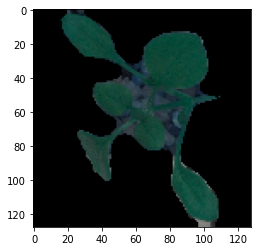

In [38]:
plt.imshow(X_test[59])
pred = model.predict(X_test[59].reshape(1, 128, 128, 3))
act = np.argmax(Y_test[59])
print("Predicted class: {}".format(le.classes_[pred.argmax()]))
print("\n Actual class: {}".format(le.classes_[act]))
print("\n Predicted label:", pred.argmax())
print("\n Softmax Outputs:", pred)
print("\n Sum of softmax outputs:",pred.sum())



The model correctly predicted Common Chickweed.
From the above predictions, we can see one wrong predition.